In [1]:
! git clone https://github.com/Bogacz-Group/PredictiveCoding.git
%cd PredictiveCoding
! pip install -r requirements.txt

Cloning into 'PredictiveCoding'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 219 (delta 1), reused 1 (delta 1), pack-reused 213 (from 1)
Receiving objects: 100% (219/219), 3.58 MiB | 24.61 MiB/s, done.
Resolving deltas: 100% (105/105), done.
/content/PredictiveCoding
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

import predictive_coding as pc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using {device}')

using cuda


# loading the data

In [3]:
# set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)

n_train = 10000
n_val = 500
n_test = 5000
batch_size = 500

transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])
dataset_train = datasets.MNIST('./data', download=True, train=True, transform=transform)
dataset_eval = datasets.MNIST('./data', download=True, train=False, transform=transform)

# Randomly sample the train dataset
train_dataset = torch.utils.data.Subset(dataset_train, random.sample(range(len(dataset_train)), n_train))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Randomly sample the val dataset
val_dataset, test_dataset, not_used = torch.utils.data.random_split(dataset_eval, [n_val, n_test, dataset_eval.__len__()-n_val-n_test])

print(f'train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}')

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.56MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 64.3kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 850kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.15MB/s]

train: 10000, val: 500, test: 5000


# Defining the model

In [4]:
input_size = 10
hidden_size = 256
hidden2_size = 256
output_size = 28*28

activation_fn = nn.ReLU

pc_model = nn.Sequential(
      nn.Linear(input_size, hidden_size),
      activation_fn(),
      pc.PCLayer(),
      nn.Linear(hidden_size, hidden2_size),
      activation_fn(),
      pc.PCLayer(),
      nn.Linear(hidden2_size, output_size)
  )

pc_model.train()
pc_model.to(device)

Sequential(
  (0): Linear(in_features=10, out_features=256, bias=True)
  (1): ReLU()
  (2): PCLayer()
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): ReLU()
  (5): PCLayer()
  (6): Linear(in_features=256, out_features=784, bias=True)
)

# Defining the model trainer

In [5]:
# number of neural activity updates
T = 20
# optimizer for activity updates
optimizer_x_fn = optim.Adam
optimizer_x_kwargs = {'lr': 0.1}
# optimizer for weight updates
optimizer_p_fn = optim.Adam
optimizer_p_kwargs = {"lr": 0.001, "weight_decay":0.001}

trainer = pc.PCTrainer(pc_model,
    T = T,
    update_x_at = "all",
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    update_p_at= "last",
    plot_progress_at=[]
)


# unitlity functions

In [6]:
def loss_fn(output, _target):
    return 0.5*(output - _target).pow(2).sum()

# This class contains the parameters of the prior mean \mu parameter (see figure)
class BiasLayer(nn.Module):
    def __init__(self, out_features, offset=0.):
        super(BiasLayer, self).__init__()
        self.bias = nn.Parameter(offset*torch.ones(out_features) if offset is not None else 2*np.sqrt(out_features)*torch.rand(out_features)-np.sqrt(out_features), requires_grad=True)

    def forward(self, x):
        return torch.zeros_like(x) + self.bias  # return the prior mean \mu witht the same shape as the input x to make sure the batch size is the same


def test_normal(model, dataset, batch_size=1000):
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # add bias layer for inferece
    test_model = nn.Sequential(
        BiasLayer(10, offset=0.),
        pc.PCLayer(),
        model
    )
    test_model.train()
    test_model.to(device)

    # make pc_trainer for test_model
    trainer_normal_test = pc.PCTrainer(test_model,
        T = 100,
        update_x_at = "all",
        optimizer_x_fn = optimizer_x_fn,
        optimizer_x_kwargs = optimizer_x_kwargs,
        update_p_at = "never",
        optimizer_p_fn = optimizer_p_fn,
        optimizer_p_kwargs = optimizer_p_kwargs,
        plot_progress_at=[]
    )

    correct_count, all_count = 0., 0.
    for data, labels in (test_loader):
        pseudo_input = torch.zeros(data.shape[0], 10)
        data, labels, pseudo_input = data.to(device), labels.to(device), pseudo_input.to(device)

        # MAP inference
        trainer_normal_test.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn, loss_fn_kwargs={'_target':data}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
        pred = torch.max(test_model[1].get_x(), dim=1)
        correct = (pred.indices == labels).long()
        correct_count += correct.sum()
        all_count += correct.size(0)
    return round((correct_count / all_count).item(), 4)

# Model training

Epoch 1: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Epoch 1 - Val acc: 0.68


Epoch 2: 100%|██████████| 20/20 [00:02<00:00,  7.09it/s]


Epoch 2 - Val acc: 0.806


Epoch 3: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Epoch 3 - Val acc: 0.824


Epoch 4: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Epoch 4 - Val acc: 0.832


Epoch 5: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


Epoch 5 - Val acc: 0.854


Epoch 6: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Epoch 6 - Val acc: 0.848


Epoch 7: 100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


Epoch 7 - Val acc: 0.852


Epoch 8: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Epoch 8 - Val acc: 0.846


Epoch 9: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Epoch 9 - Val acc: 0.846


Epoch 10: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


Epoch 10 - Val acc: 0.848
Test accuracy: 0.84


Text(0.5, 1.0, 'Normal PC with test accuracy: 0.84')

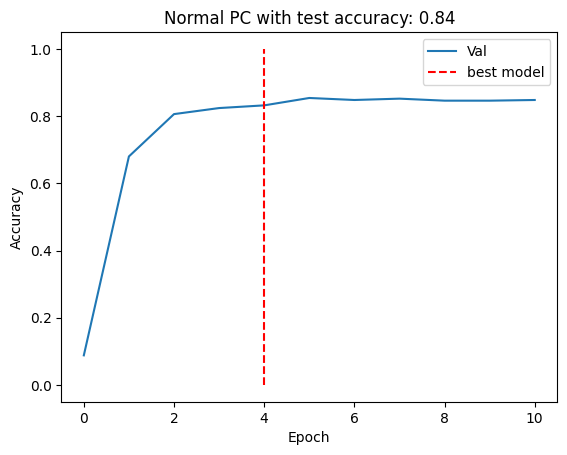

In [7]:
epochs = 10
batch_size = 500

best_val_acc = 0
best_model = copy.deepcopy(pc_model.state_dict())
best_model_idx = None

train_acc = [test_normal(pc_model, test_dataset)]
val_acc = [test_normal(pc_model, val_dataset)]
for epoch in range(epochs):
    for data, label in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        data, label = data.to(device), label.to(device)
        # labels to one-hot
        labels_one_hot = F.one_hot(label).float()
        trainer.train_on_batch(inputs=labels_one_hot, loss_fn=loss_fn, loss_fn_kwargs={'_target':data}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
    val_acc.append(test_normal(pc_model, val_dataset))
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        best_model = copy.deepcopy(pc_model.state_dict())
        best_model_idx = epoch
    print(f'Epoch {epoch+1} - Val acc: {val_acc[-1]}')


test_model = pc_model
test_model.train()
test_model.load_state_dict(best_model, strict=False)
test_model.to(device)
acc_test = test_normal(test_model, test_dataset)
print(f'Test accuracy: {acc_test}')


plt.plot(val_acc, label='Val')
plt.vlines(best_model_idx, 0, 1, colors="r", linestyles="dashed", label="best model")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Normal PC with test accuracy: {acc_test}')

# Data generation

100%|██████████| 10/10 [00:00<00:00, 326.91it/s]


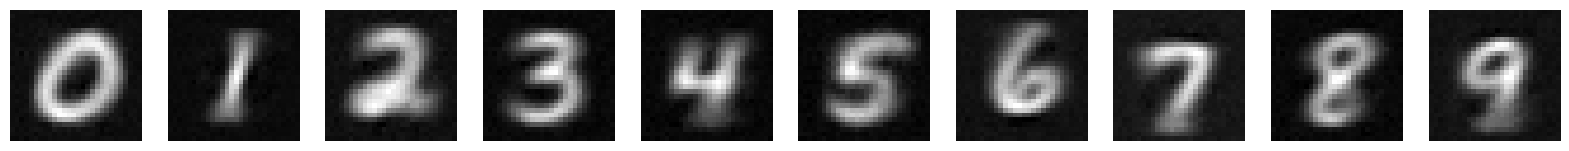

In [8]:
# conditional generation

test_model.eval() # this changes the code to perform a forward pass insteady of minimising prediction errors

imgs = []
for i in tqdm(range(10)):
    input = torch.zeros(1, 10)
    input[0, i] = 1
    input = input.to(device)

    img = test_model(input)
    imgs.append(img.cpu().detach().numpy().reshape(28, 28))

# show 10 images one for each digit
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(imgs[i], cmap='gray')
    ax[i].axis('off')

# Denoising data

100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


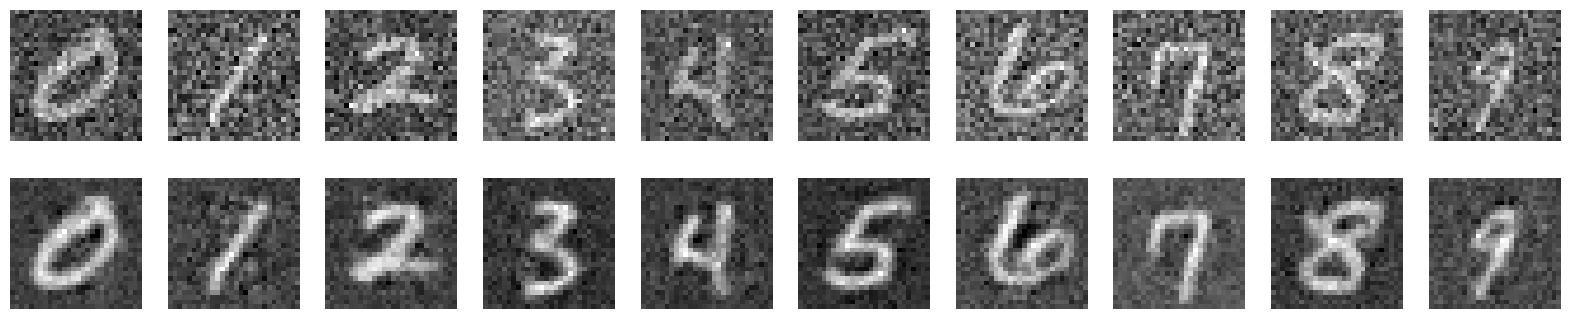

In [9]:
# conditional generation

# make pc_trainer for generation
trainer_normal_generation = pc.PCTrainer(test_model,
    T = 100,
    update_x_at = "all",
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = "never",
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= []
)

test_model.train()

test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=False)
data, labels = next(iter(test_dataloader))
data, labels = data.to(device), labels.to(device)

noisy_imgs=[]
predicted_imgs = []
for i in tqdm(range(10)):
    # get one image from data with correct label
    idx = torch.where(labels == i)[0][0]
    img = data[idx].unsqueeze(0)
    img = img + torch.randn_like(img)*0.3
    label = torch.zeros(1, 10)
    label[0, i] = 1
    label = label.to(device)

    results = trainer_normal_generation.train_on_batch(inputs=label, loss_fn=loss_fn, loss_fn_kwargs={"_target": img}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False, is_return_outputs=True)

    predicted_imgs.append(results['outputs'][-1].cpu().detach().numpy().reshape(28, 28))
    noisy_imgs.append(img.cpu().detach().numpy().reshape(28,28))

# show 10 images one for each digit
fig, ax = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    ax[0,i].imshow(noisy_imgs[i], cmap='gray')
    ax[0,i].axis('off')
    ax[1,i].imshow(predicted_imgs[i], cmap='gray')
    ax[1,i].axis('off')

## Handling missing data

100%|██████████| 10/10 [04:20<00:00, 26.08s/it]


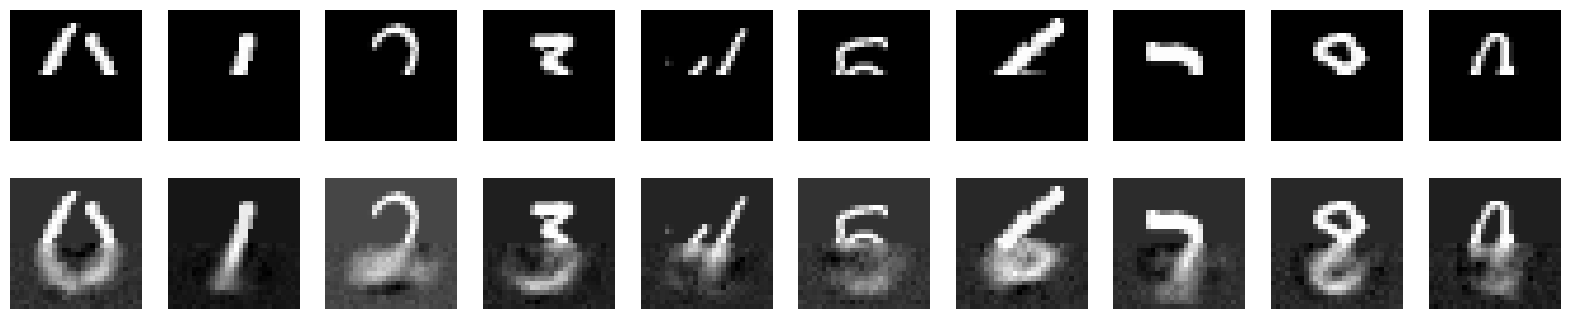

In [10]:
# Filling in missing pixels
# make pc_trainer for generation
trainer_normal_generation = pc.PCTrainer(test_model,
    T = 10000,
    update_x_at = "all",
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = "never",
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= []
)

test_model.train()


def loss_fn_normal_masked(output, _target):
    return 0.5*(output[:,:28*28//2] - _target[:,:28*28//2]).pow(2).sum()

imgs = []
data, labels = next(iter(train_loader))
for i in tqdm(range(10)):
    # get one image from data with correct label
    idx = torch.where(labels == i)[0][0]
    img = data[idx].unsqueeze(0).to(device)
    label = torch.zeros(1, 10)
    label[0, i] = 1
    label = label.to(device)
    # minmise errors
    results = trainer_normal_generation.train_on_batch(inputs=label, loss_fn=loss_fn_normal_masked, loss_fn_kwargs={"_target": img}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False, is_return_outputs=True)
    # get outputs
    output_img = results['outputs'][-1].cpu().detach().numpy().reshape(28, 28)
    output_img[:14, :] = img.cpu().detach().numpy().reshape(28, 28)[:14, :]
    imgs.append(output_img)

# show 10 images one for each digit
fig, ax = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    input = np.copy(imgs[i])
    input[14:,:]=0
    ax[0,i].imshow(input, cmap='gray')
    ax[0,i].axis('off')
    ax[1,i].imshow(imgs[i], cmap='gray')
    ax[1,i].axis('off')